# Линейная регрессия

Попробуем улучшить прогноз, построенный в excel с использованием **предсказ.ets**. Его точность составила:
- MAE = 6 871
- MAPE = 14% 
- RMSE = 9 034 

Однако, стоит отметить общую точность прогноза. Так, если рассматривать весь прогнозируемый период, то общая ошибка составила 18 615, это примерно 1%. (уточнение: это касается только конкретного терминала)  
С дневной ошибкой все хуже (14%).  
  
В этом ноутбуке проверим несколько линейных моделей, дополнительно сгенерируем некоторые признаки для улучшения качества и посмотрим на значимость фичей.  

Данные представляют из себя временной ряд с количеством обработанных грузов.

In [446]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from catboost import CatBoostRegressor

import warnings                                  
warnings.filterwarnings('ignore')

sns.set()
plt.style.use("ggplot")
%matplotlib inline

In [447]:
X_train, X_test = [], []

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(22, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.7, color='black')
        plt.plot(upper, "r--", alpha=0.7, color='black')
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(25, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R2:',  metrics.r2_score(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    pass

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats

In [448]:
# метрики
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
RMSE
R2
MAPE


In [449]:
source = pd.read_csv('E:\\Analytics\\Projects\\forecast_cargo_flow\\data\\sample_csu_since_2019.csv', delimiter=';', parse_dates=['r_date'])

In [450]:
source.head()

,r_date,warehouse_id,measure_unit_id,fact,type_flow_id
0,2019-01-01,28999900,1,0,1
1,2019-01-01,28999900,1,0,2
2,2019-01-01,28999900,1,0,3
3,2019-01-02,28999900,1,2,1
4,2019-01-02,28999900,1,0,2


Тестовый датасет содержит данные только по одному терминалу (28999900). Единицы измерения так же представлены в одном виде (экспресс накладные).  
Тип потока имеет три значения, но для упрощения, мы сгруппируем данные только по дате. Соответсвеннно, остальные поля удалим.

In [451]:
df = source[['fact', 'r_date']] # оставляем только дату и факт
df = df.groupby(['r_date']).sum() # группируем по дате
df.reset_index(inplace=True) # сбрасываем индексы

df['r_date'] = pd.to_datetime(df['r_date']) # r_date в дату
df['fact'] = pd.to_numeric(df['fact']) # факт в числовой тип

По графику, расположенному ниже, можно увидеть некоторую сезонность. С ноября происходит увеличение грузового потока, наибольшие значения приходятся на декабрь.  
После этого, особенно в первые дни января, происходит спад.  
Так же, в апреле 2020 наблюдалось сокращение потока, что можно связать с карантинными мерами в период эпидемии ковида.

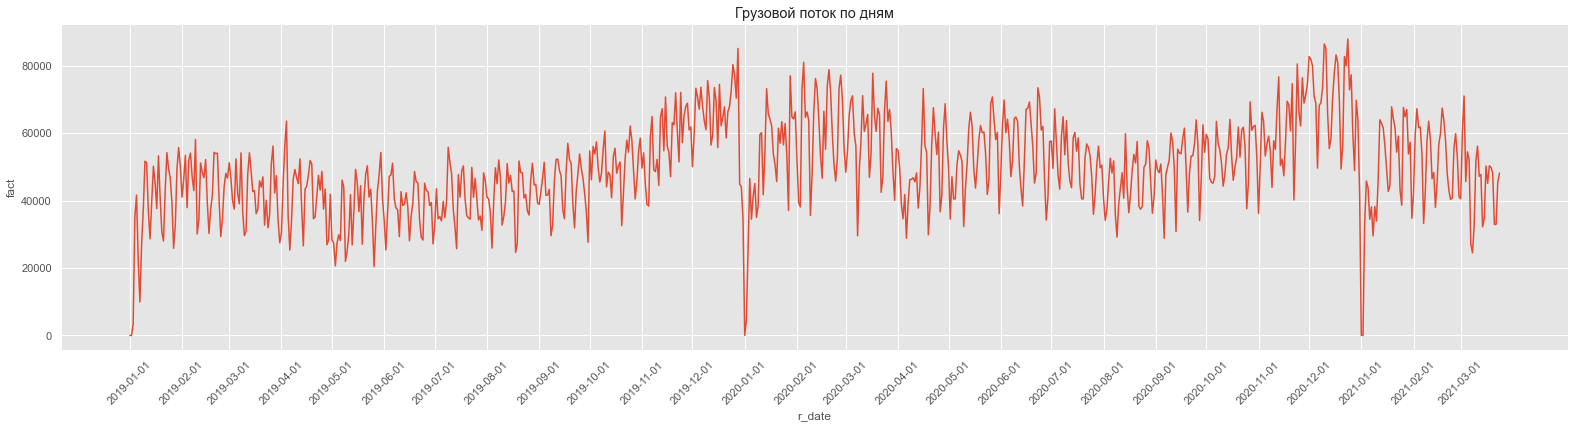

In [452]:
months = df['r_date'].dt.strftime("%Y-%m-01").unique().tolist()

plt.figure(figsize=(27, 6))
sns.lineplot(data=df, x="r_date", y="fact")
plt.xticks(months, rotation=45)
plt.title('Грузовой поток по дням')
plt.show()

## Linear regression и минимум признаков 

Мы будем пробовать предсказывать данные с конца февраля по март, а именно на 52 дня.
Простая линейная модель имеет один существенный недостаток: необходимо создать такое же количество временных лагов, на которое будет прогноз.  
Таким образом, добавим фактическое значение, равное 52 дням назад.

In [453]:
past_date = 52

for i in range(1, past_date+1):
    df["lag_{}".format(i)] = df.fact.shift(i)

df.dropna(inplace=True) # удаляем пустые строки

In [454]:
df.info() # получившиеся признаки

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762 entries, 52 to 813
Data columns (total 54 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   r_date  762 non-null    datetime64[ns]
 1   fact    762 non-null    int64         
 2   lag_1   762 non-null    float64       
 3   lag_2   762 non-null    float64       
 4   lag_3   762 non-null    float64       
 5   lag_4   762 non-null    float64       
 6   lag_5   762 non-null    float64       
 7   lag_6   762 non-null    float64       
 8   lag_7   762 non-null    float64       
 9   lag_8   762 non-null    float64       
 10  lag_9   762 non-null    float64       
 11  lag_10  762 non-null    float64       
 12  lag_11  762 non-null    float64       
 13  lag_12  762 non-null    float64       
 14  lag_13  762 non-null    float64       
 15  lag_14  762 non-null    float64       
 16  lag_15  762 non-null    float64       
 17  lag_16  762 non-null    float64       
 18  lag_17  7


Разделяем датасет на треннировочную и тестовую выборки и обучаем модель

In [455]:
tscv = TimeSeriesSplit(n_splits=5)

try:
    df.set_index(['r_date'], inplace=True)
except:
    pass

y = df.dropna().fact
X = df.dropna().drop(['fact'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [456]:
# обучение модели в 2 строки
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

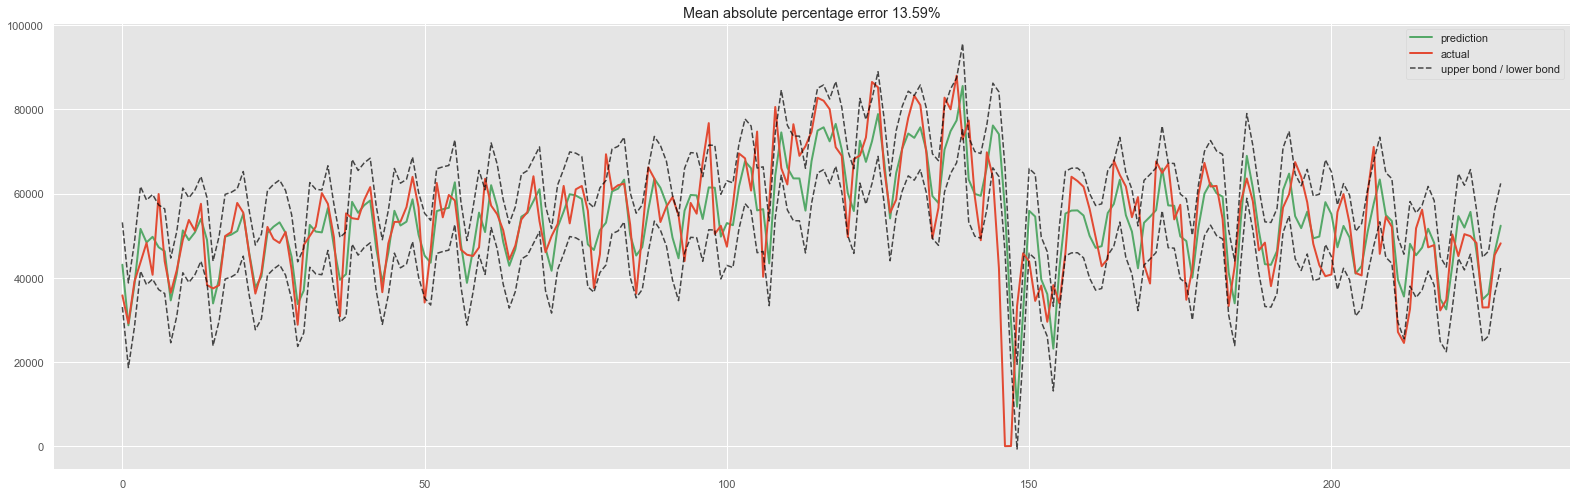

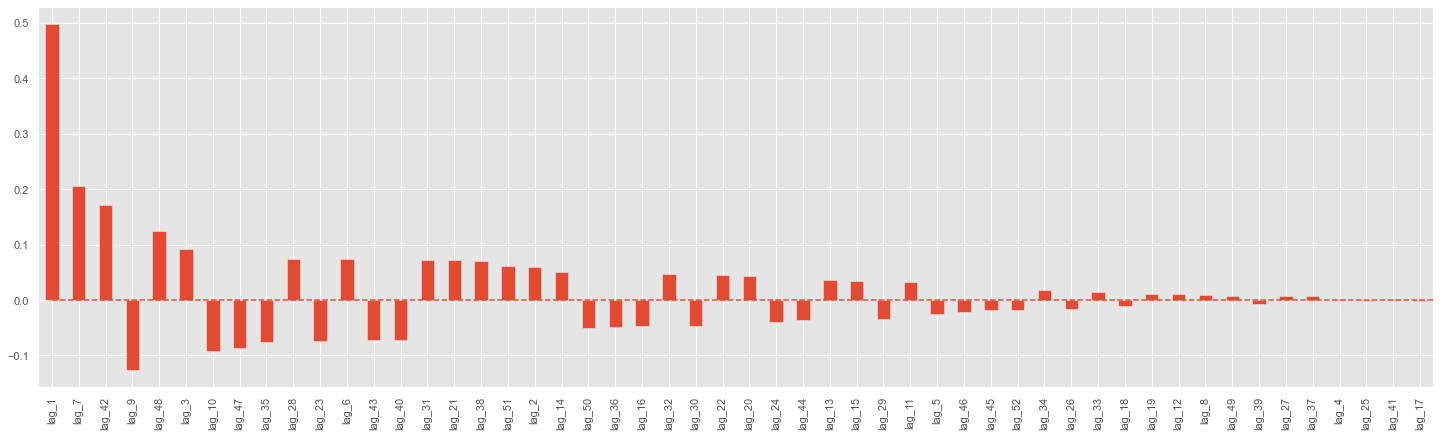

In [457]:
plotModelResults(lr, X_train=X_train, X_test=X_test, plot_intervals=True)
plotCoefficients(lr)

In [458]:
prediction = lr.predict(X_test)
measured_metrics["simple_linreg"] = dataframe_metrics(prediction, y_test)
measured_metrics

,error_type,simple_linreg
0,MAE,6538.931099
1,RMSE,9064.306052
2,R2,0.314067
3,MAPE,13.591863


Получается, что самая простая регрессия не уступает по точности предсказ.ets.    
Как видно, модель при прогнозе, в основном, опирается на 1ый и 7ой временной лаг.  
Но 14%, все же, еще большая ошибка, попробуем и другие модели

## Добавление новых признаков и регуляризация

In [459]:
df = source[['fact', 'r_date']] # оставляем только дату и факт
df = df.groupby(['r_date']).sum() # группируем по дате
df.reset_index(inplace=True) # сбрасываем индексы
df['r_date'] = pd.to_datetime(df['r_date']) # r_date в дату
df['fact'] = pd.to_numeric(df['fact']) # факт в числовой тип

past_date = 52

for i in range(1, past_date+1):
    df["lag_{}".format(i)] = df.fact.shift(i)

df.dropna(inplace=True) # удаляем пустые строки

Добавим скользящее среднее значение за неделю и месяц

In [460]:
df["mean_week_lag"] = df["fact"].shift(1).rolling(window=7).mean() # среднее за 7 дей
df["mean_month_lag"] = df["fact"].shift(1).rolling(window=30).mean() # среднее за 30 дней

Добавим несколько признаков из даты

In [461]:
df["year"] = df["r_date"].dt.year # Создаем колонку "Год" из поля "Дата"
df["month"] = df["r_date"].dt.month # Создаем колонку "Месяц"
df["weekday"] = df["r_date"].dt.weekday # Создаем колонку "День недели"

df = pd.get_dummies(df, columns=["year", "month", "weekday"]) # Преобразуем колонки "даты" в бинарные (0/1) колонки

In [462]:
df.info() # датасет с новыми признаками

<class 'pandas.core.frame.DataFrame'>
Int64Index: 762 entries, 52 to 813
Data columns (total 78 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   r_date          762 non-null    datetime64[ns]
 1   fact            762 non-null    int64         
 2   lag_1           762 non-null    float64       
 3   lag_2           762 non-null    float64       
 4   lag_3           762 non-null    float64       
 5   lag_4           762 non-null    float64       
 6   lag_5           762 non-null    float64       
 7   lag_6           762 non-null    float64       
 8   lag_7           762 non-null    float64       
 9   lag_8           762 non-null    float64       
 10  lag_9           762 non-null    float64       
 11  lag_10          762 non-null    float64       
 12  lag_11          762 non-null    float64       
 13  lag_12          762 non-null    float64       
 14  lag_13          762 non-null    float64       
 15  lag_1

Отлично, добавили в датасет новых признаков. Скорее всего, многие из них будут скоррелированы, посмотрим на графике ниже.

<AxesSubplot:>

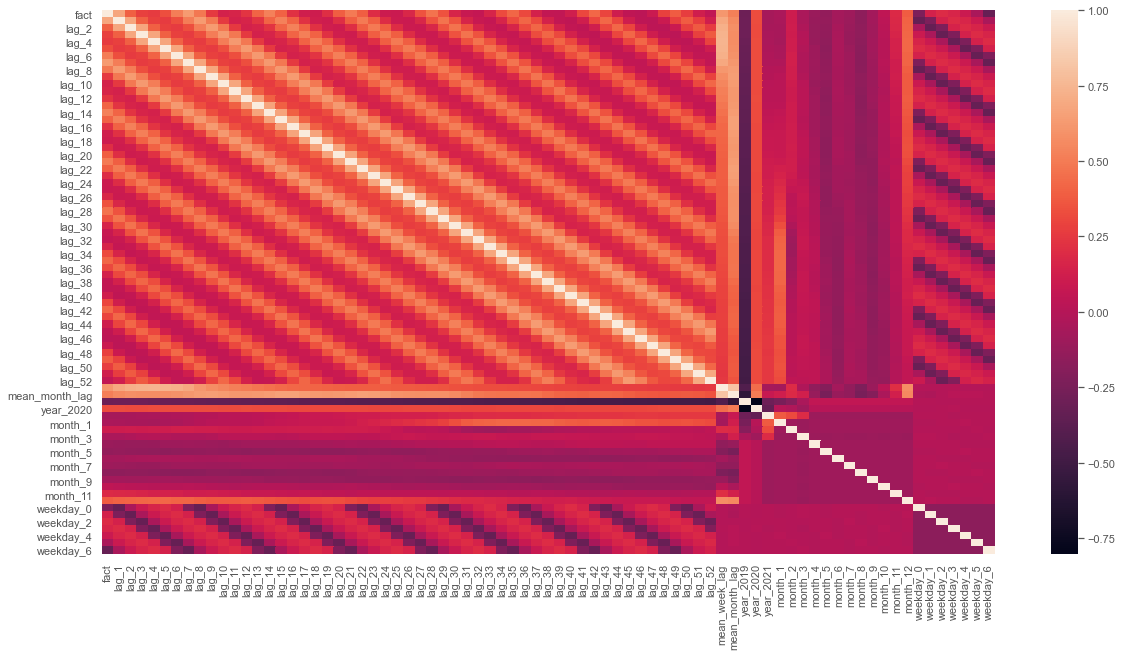

In [463]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr())

Собственно, да, много скоррелированных признаков от которых надо будет избавиться. Плюс между фактом и лагами заметна недельная периодичность.

Так как теперь у нас данные в разном масштабе - десятки тысяч в лагах и единицы в категориях, имеет смысл привести всё к одному масштабу, чтобы можно было по-прежнему исследовать коэффициенты модели. Для этого воспользуемся StandardScaler

In [464]:
scaler = StandardScaler()

In [465]:
numerical = [col for col in df.columns if 'lag' in col] # переменные для стандартизации

In [466]:
tscv = TimeSeriesSplit(n_splits=5)

df.reset_index(inplace=True)
df.set_index(['r_date'], inplace=True)

try:
    df.drop(['index'], axis=1, inplace=True)
except:
    pass

y = df.dropna().fact
X = df.dropna().drop(['fact'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = X_train
X_test_scaled = X_test

X_train_scaled_numeric = scaler.fit_transform(X_train[numerical])
X_test_scaled_numeric = scaler.transform(X_test[numerical])

X_train_scaled[numerical] = X_train_scaled_numeric
X_test_scaled[numerical] = X_test_scaled_numeric

# Без стандартизации точность ридж регрессии составила 18%
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

## Ридж регрессия

In [467]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
        cv=TimeSeriesSplit(max_train_size=None, n_splits=5))

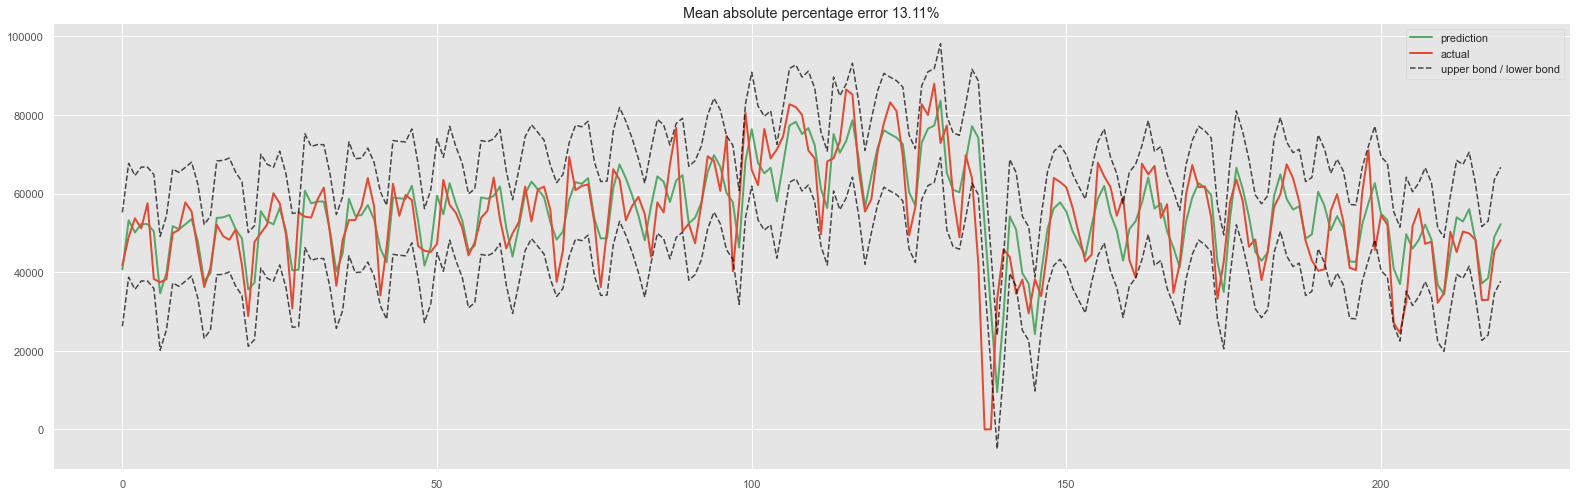

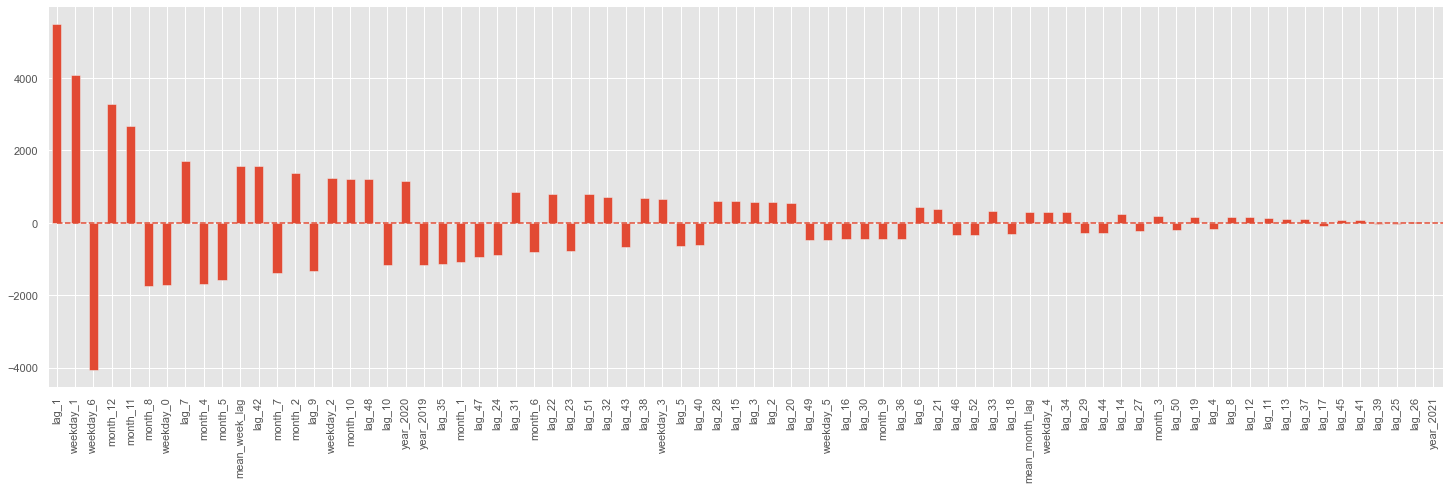

In [468]:
plotModelResults(ridge, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(ridge)

In [469]:
prediction = ridge.predict(X_test_scaled)
measured_metrics["ridge"] = dataframe_metrics(prediction, y_test)
measured_metrics

,error_type,simple_linreg,ridge
0,MAE,6538.931099,6391.692223
1,RMSE,9064.306052,8778.246192
2,R2,0.314067,0.361963
3,MAPE,13.591863,13.105314


Ридж регрессия получилась чуть лучше. Хорошо видно, как признаки приближаются к нулю по мере убывания важности.  
Получилось, что, в основном, важно вчерашнее значение. По вторникам много грузов, а вот в воскресенье наоборот - мало грузов. В декабре и в ноябре увеличивается поток, а в августе - спадает.

## Лассо регрессия

In [470]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

LassoCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5))

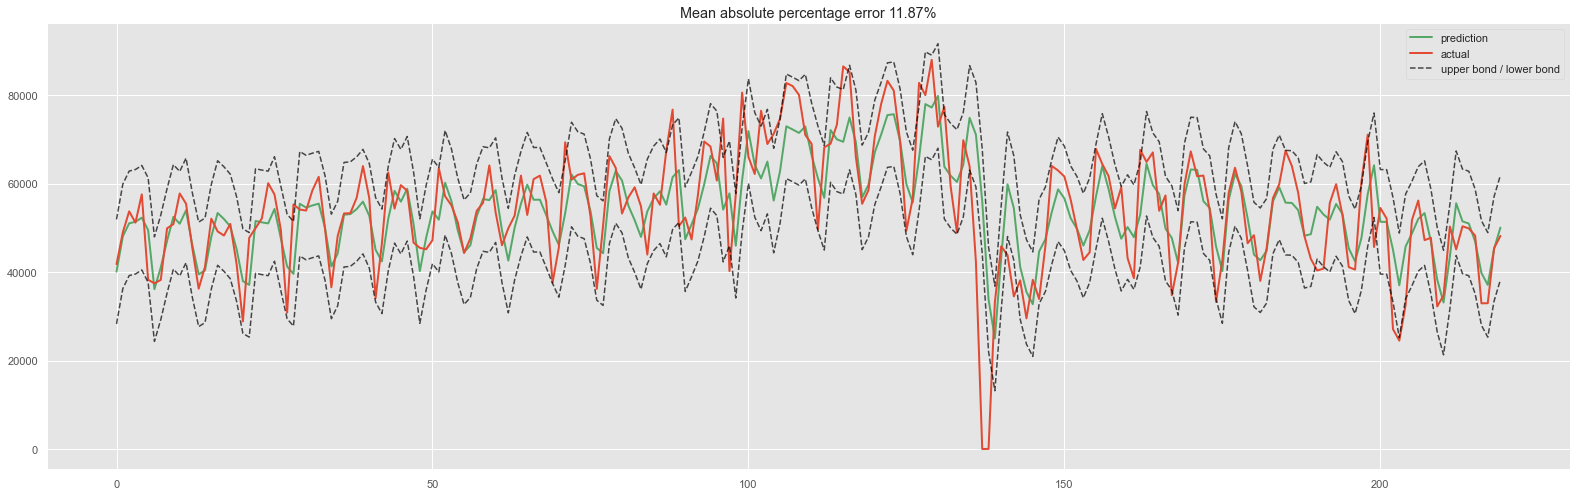

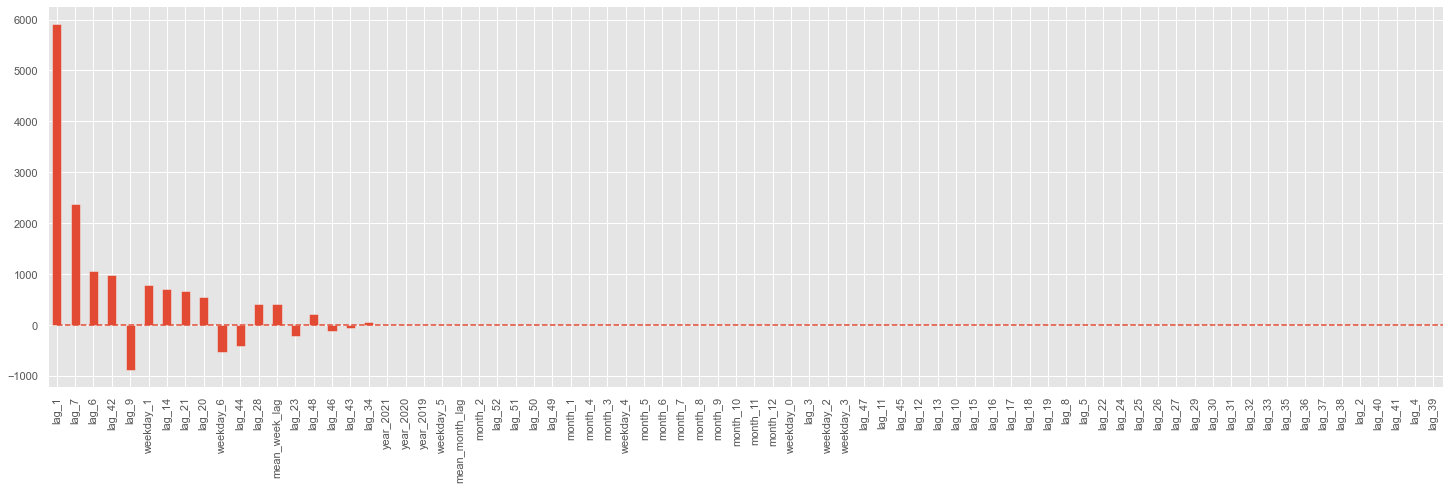

In [471]:
plotModelResults(lasso, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lasso)

In [472]:
prediction = lasso.predict(X_test_scaled)
measured_metrics["lasso"] = dataframe_metrics(prediction, y_test)
measured_metrics

,error_type,simple_linreg,ridge,lasso
0,MAE,6538.931099,6391.692223,6216.142477
1,RMSE,9064.306052,8778.246192,8891.789778
2,R2,0.314067,0.361963,0.119109
3,MAPE,13.591863,13.105314,11.869915


С лассо регрессией становится получше, с другой немного выросла среднеквадратическая ошибка.  
В основном модель интересют 1ый и 7ой лаги. В все остальное считается менее значимым, либо совсем не используется.

## Бустинг?

In [473]:
param_grid = {    
    'n_estimators': [50, 70, 100, 130],
    'learning_rate': [0.62, 0.65, 0.68, 0.7, 0.72, 0.75]
}

# score = metrics.make_scorer(metrics.mean_absolute_error)

regressors = []
regressors.append(AdaBoostRegressor(loss='linear', random_state=42))
regressors.append(GradientBoostingRegressor(random_state=42))

for model in regressors:
    gbr = GridSearchCV(model, param_grid, cv=tscv, return_train_score=True) # scoring=score)
    gbr.fit(X_train, y_train)
    print(f'{gbr.best_estimator_} - best score: {gbr.best_score_}')
    print(gbr.best_params_)

AdaBoostRegressor(learning_rate=0.7, n_estimators=70, random_state=42) - best score: 0.2323977430119692
{'learning_rate': 0.7, 'n_estimators': 70}
GradientBoostingRegressor(learning_rate=0.68, n_estimators=50, random_state=42) - best score: -0.3534788037819001
{'learning_rate': 0.68, 'n_estimators': 50}


In [474]:
gbr = AdaBoostRegressor(loss='linear', random_state=42, learning_rate=0.7, n_estimators=70)
gbr.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.7, n_estimators=70, random_state=42)

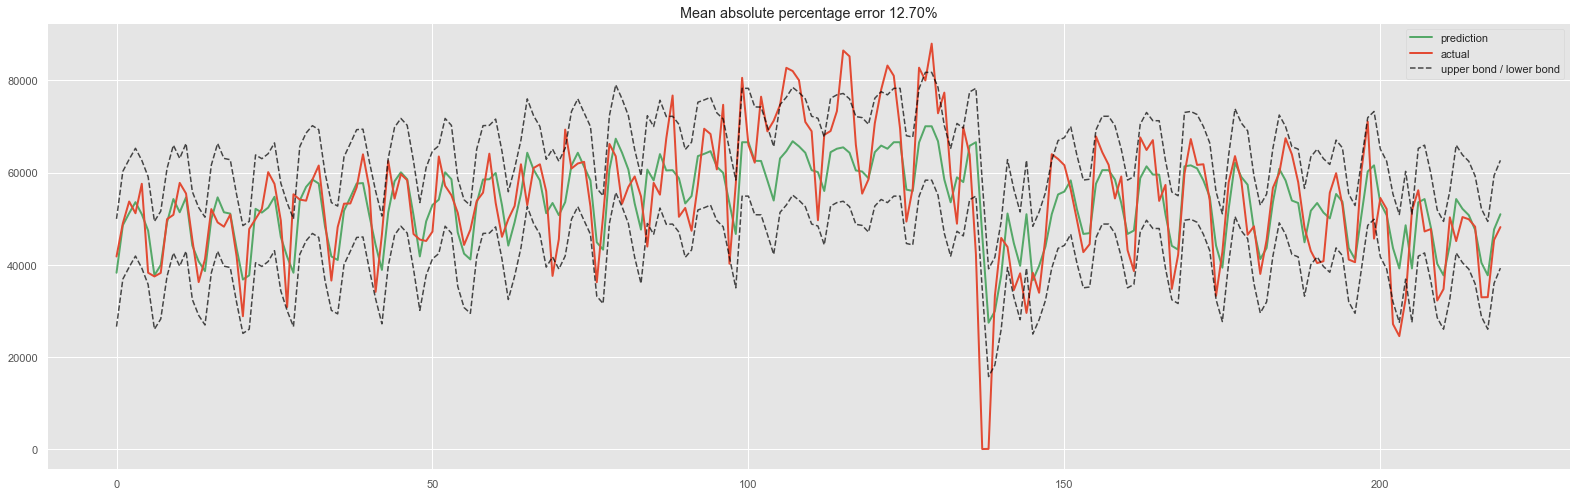

In [475]:
plotModelResults(gbr, X_train=X_train, X_test=X_test, plot_intervals=True)

In [476]:
prediction = gbr.predict(X_test)
measured_metrics["gbr"] = dataframe_metrics(prediction, y_test)
measured_metrics

,error_type,simple_linreg,ridge,lasso,gbr
0,MAE,6538.931099,6391.692223,6216.142477,6618.831662
1,RMSE,9064.306052,8778.246192,8891.789778,8901.837639
2,R2,0.314067,0.361963,0.119109,-0.097952
3,MAPE,13.591863,13.105314,11.869915,12.702727


По метрикам такая модель получилась хуже. Так же, стоит учитывать, что модели, с деревьями внутри, плохо справляются с трендами.